Median Age: 74.25


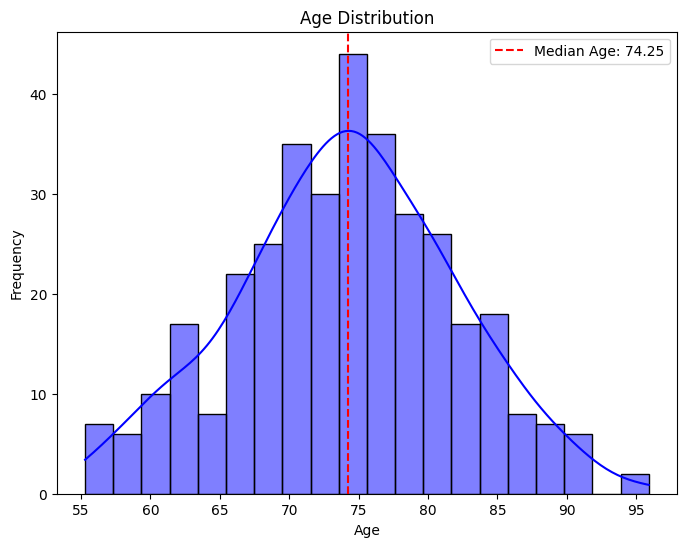

/tmp/ipykernel_18456/3646991604.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')


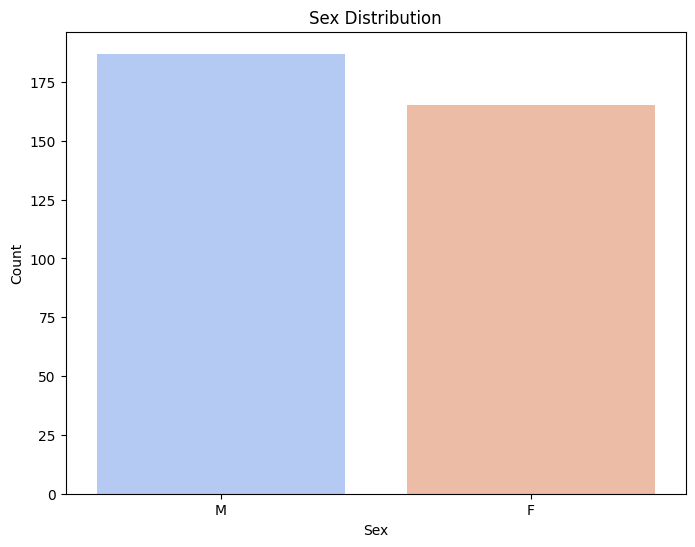

/tmp/ipykernel_18456/3646991604.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')


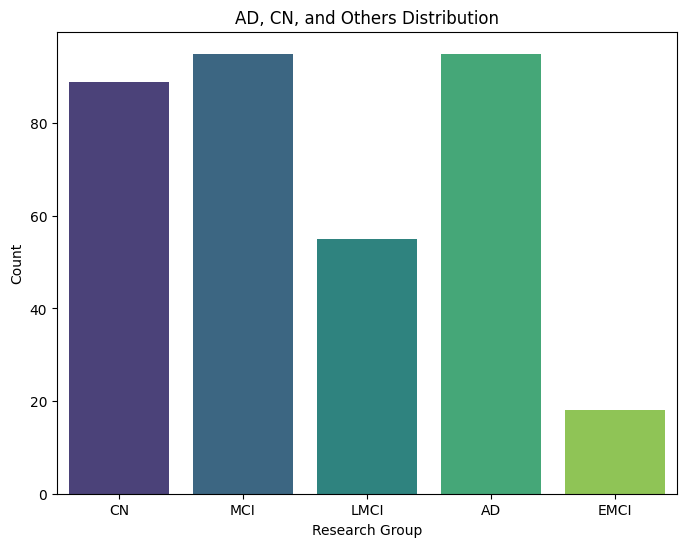

Sex             F   M
ResearchGroup        
AD             40  55
CN             52  37
EMCI            8  10
LMCI           23  32
MCI            42  53
AD_men: 55 subjects
AD_women: 40 subjects
CN_men: 37 subjects
CN_women: 52 subjects
Other_men: 95 subjects
Other_women: 73 subjects
Train set: 244 subjects
Validation set: 50 subjects
Test set: 58 subjects


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
project_dir = '/home/diego/Escritorio/azheimer/'  # Adjust to your path
csv_path = os.path.join(project_dir, 'DataBaseSubjects.csv')
tensor_data_dir = os.path.join(project_dir, 'TensorData')

# Load the CSV file
subjects_df = pd.read_csv(csv_path)

# Calculate the median age and print it
median_age = subjects_df['Age'].median()
print(f"Median Age: {median_age}")

# Plot the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(subjects_df['Age'], bins=20, kde=True, color='blue')
plt.axvline(median_age, color='red', linestyle='--', label=f'Median Age: {median_age}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the sex distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot the distribution of AD, CN, and Others
plt.figure(figsize=(8, 6))
sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')
plt.title('AD, CN, and Others Distribution')
plt.xlabel('Research Group')
plt.ylabel('Count')
plt.show()

# Group subjects by Research Group and Sex
grouped_data = subjects_df.groupby(['ResearchGroup', 'Sex']).size().unstack().fillna(0)
print(grouped_data)

# Initialize dictionaries for storing tensor paths by group and sex
tensor_groups = {
    'AD_men': [],
    'AD_women': [],
    'CN_men': [],
    'CN_women': [],
    'Other_men': [],
    'Other_women': []
}

# Iterate over subjects and assign tensors to groups
for subject_id in subjects_df['SubjectID']:
    group = subjects_df[subjects_df['SubjectID'] == subject_id]['ResearchGroup'].values[0]
    sex = subjects_df[subjects_df['SubjectID'] == subject_id]['Sex'].values[0]
    file_name = f'{group}_tensor_{subject_id}.pt'
    file_path = os.path.join(tensor_data_dir, file_name)
    
    if os.path.exists(file_path):
        if group == 'AD':
            if sex == 'M':
                tensor_groups['AD_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['AD_women'].append(file_path)
        elif group == 'CN':
            if sex == 'M':
                tensor_groups['CN_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['CN_women'].append(file_path)
        else:  # Others
            if sex == 'M':
                tensor_groups['Other_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['Other_women'].append(file_path)

# Print the number of subjects in each group
for key, value in tensor_groups.items():
    print(f'{key}: {len(value)} subjects')

# Split data into train, validation, and test sets with equal proportions
def split_data(tensors, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    np.random.shuffle(tensors)
    n_total = len(tensors)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_set = tensors[:n_train]
    val_set = tensors[n_train:n_train + n_val]
    test_set = tensors[n_train + n_val:]
    
    return train_set, val_set, test_set

# Initialize lists for train, validation, and test sets
train_set, val_set, test_set = [], [], []

# Combine groups ensuring equal proportions of gender and research groups
for group in tensor_groups:
    train, val, test = split_data(tensor_groups[group])
    train_set.extend(train)
    val_set.extend(val)
    test_set.extend(test)

# Print final counts of train, validation, and test sets
print(f"Train set: {len(train_set)} subjects")
print(f"Validation set: {len(val_set)} subjects")
print(f"Test set: {len(test_set)} subjects")




In [2]:
# Function to normalize each channel of the tensor between 0 and 1
def normalize_tensor(tensor):
    normalized_tensor = torch.zeros_like(tensor)
    for i in range(tensor.shape[0]):  # For each channel
        channel_data = tensor[i]
        min_val = channel_data.min()
        max_val = channel_data.max()
        # Avoid division by zero
        if max_val - min_val != 0:
            normalized_tensor[i] = (channel_data - min_val) / (max_val - min_val)
        else:
            normalized_tensor[i] = channel_data - min_val
    return normalized_tensor


In [3]:
# Load the tensors and create datasets
def load_tensors(file_paths):
    tensors = []
    for fp in file_paths:
        data = torch.load(fp)
        if isinstance(data, np.ndarray):  # Convert numpy arrays to tensors
            data = torch.tensor(data)
        # Normalize the data
        data = normalize_tensor(data)
        tensors.append(data)
    return torch.stack(tensors)


# Load data for train, validation, and test sets
train_data = load_tensors(train_set)
val_data = load_tensors(val_set)
test_data = load_tensors(test_set)

# Print final dataset shapes
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

import torch

# Assuming train_set, val_set, test_set are your datasets (could be PyTorch Datasets or DataLoaders)
torch.save(train_data, 'sets/train_set.pt')
torch.save(val_data, 'sets/val_set.pt')
torch.save(test_data, 'sets/test_set.pt')


Train data shape: torch.Size([244, 3, 116, 116])
Validation data shape: torch.Size([50, 3, 116, 116])
Test data shape: torch.Size([58, 3, 116, 116])


Plotting matrices for a random subject from Train dataset: /home/diego/Escritorio/azheimer/TensorData/MCI_tensor_003_S_6954.pt


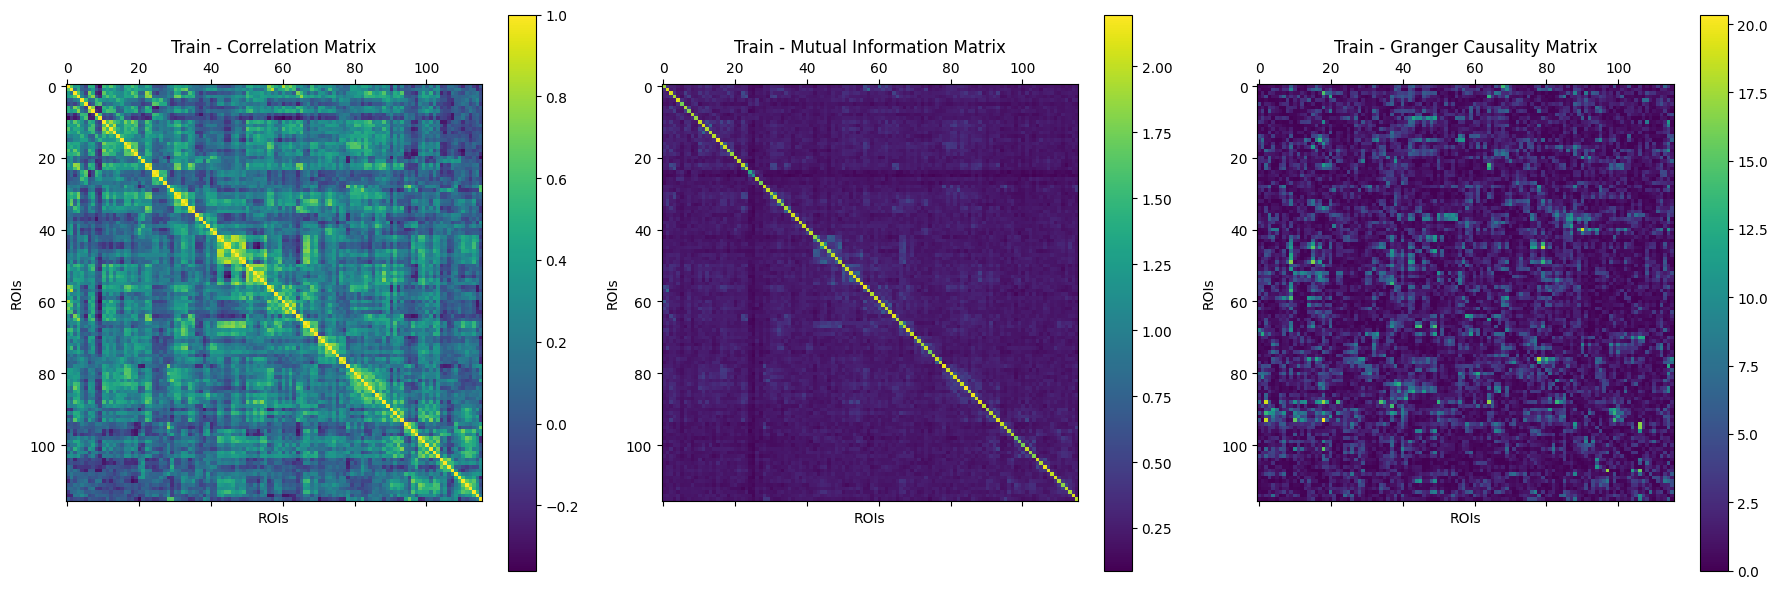

Plotting matrices for a random subject from Validation dataset: /home/diego/Escritorio/azheimer/TensorData/AD_tensor_013_S_6975.pt


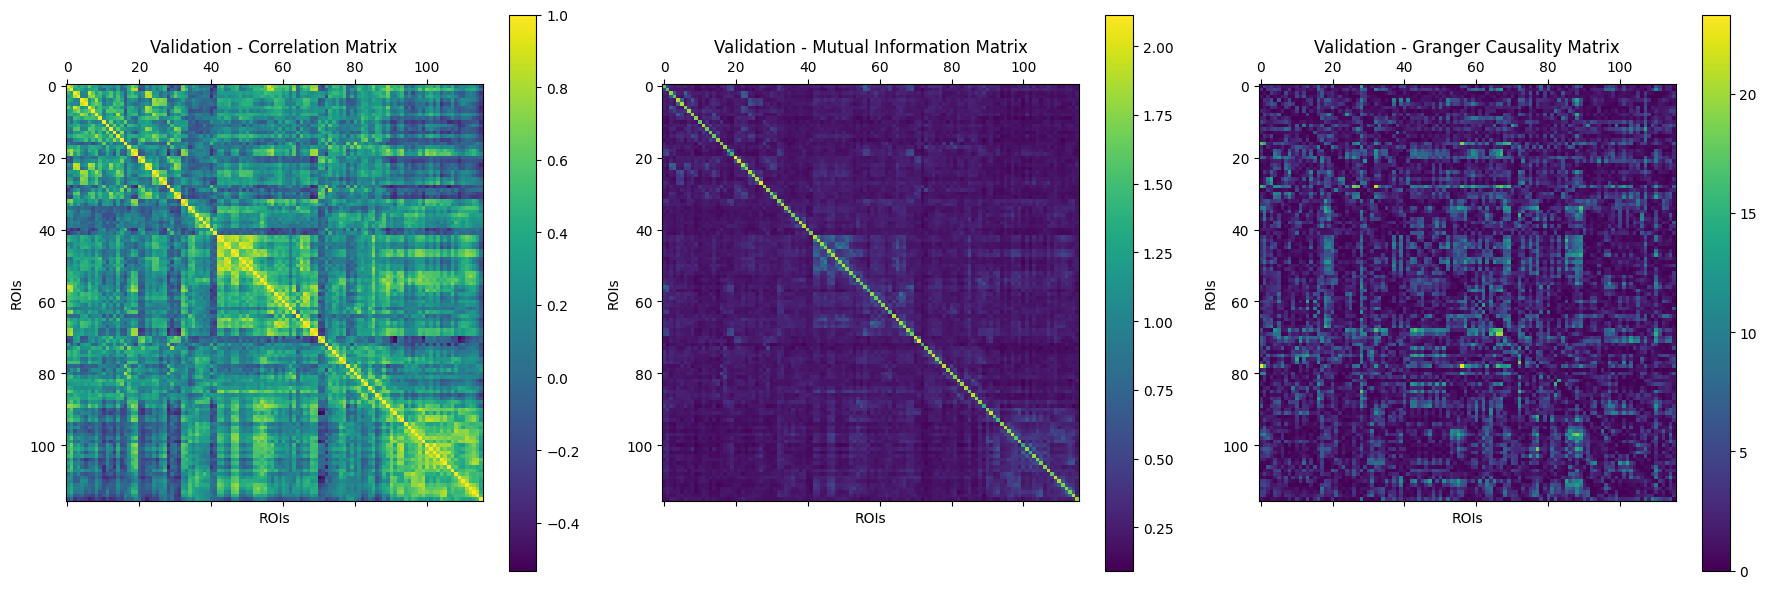

Plotting matrices for a random subject from Test dataset: /home/diego/Escritorio/azheimer/TensorData/MCI_tensor_003_S_6258.pt


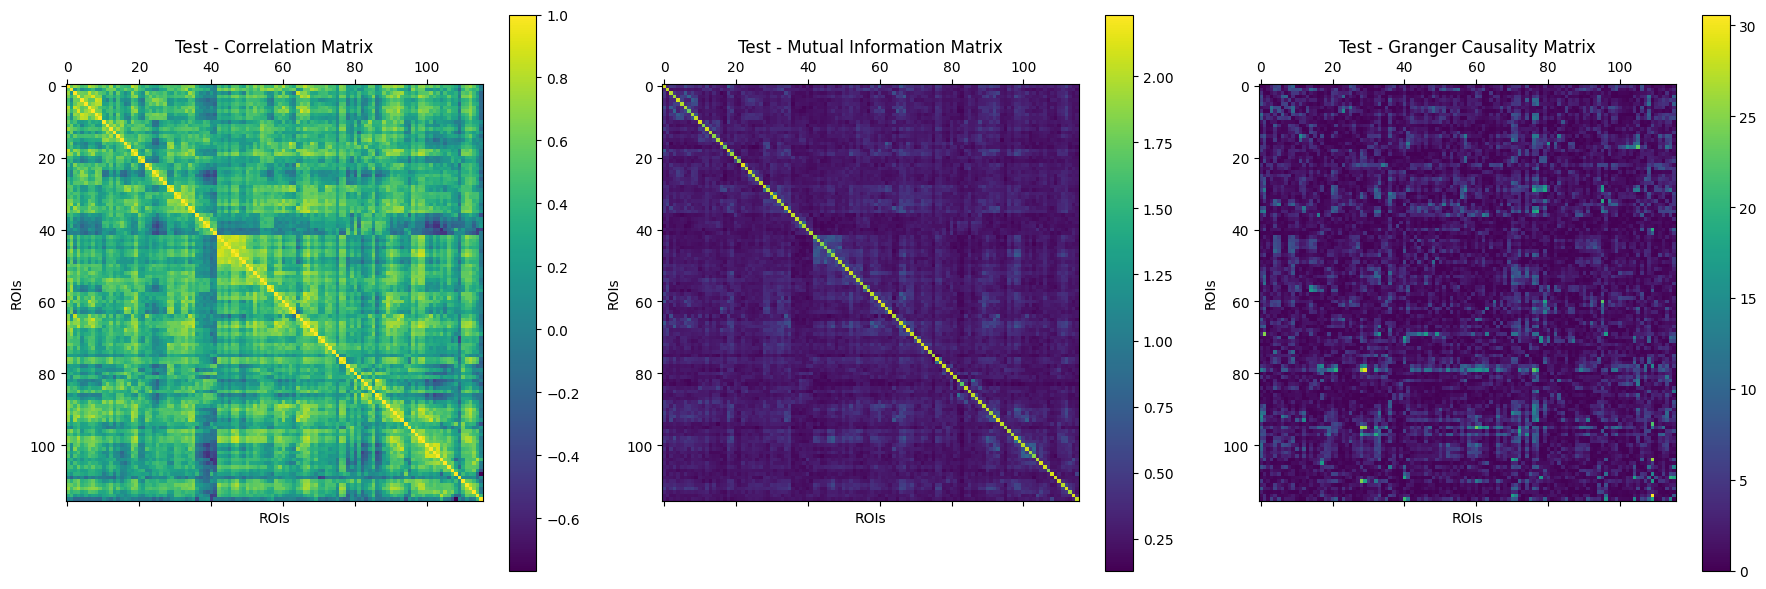

In [4]:
import random
import matplotlib.pyplot as plt

# Function to plot the three matrices for a given subject's tensor
def plot_matrices(tensor, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    matrix_titles = ['Correlation Matrix', 'Mutual Information Matrix', 'Granger Causality Matrix']

    # Loop through the three matrices
    for i in range(3):
        ax = axes[i]
        cax = ax.matshow(tensor[i], cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{title_prefix} - {matrix_titles[i]}')
        ax.set_xlabel('ROIs')
        ax.set_ylabel('ROIs')

    plt.tight_layout()
    plt.show()

# Choose a random subject from each dataset and plot their matrices
def plot_random_subject_from_dataset(dataset, dataset_name):
    random_subject = random.choice(dataset)
    print(f"Plotting matrices for a random subject from {dataset_name} dataset: {random_subject}")
    
    # Load the tensor for the randomly selected subject
    tensor = torch.load(random_subject)
    
    # Plot the matrices
    plot_matrices(tensor, dataset_name)

# Plot one random subject from train, validation, and test datasets
plot_random_subject_from_dataset(train_set, 'Train')
plot_random_subject_from_dataset(val_set, 'Validation')
plot_random_subject_from_dataset(test_set, 'Test')


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [6]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.dropout_rate = 0.2  # Dropout rate

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)    # Output: (64, 58, 58)
        self.enc_conv2 = nn.Conv2d(64, 128, 4, 2, 1)  # Output: (128, 29, 29)
        self.enc_conv3 = nn.Conv2d(128, 256, 4, 2, 1)  # Output: (256, 14, 14)
        self.enc_conv4 = nn.Conv2d(256, 512, 4, 2, 1)  # Output: (512, 7, 7)
        self.enc_conv5 = nn.Conv2d(512, 512, 4, 2, 1)  # Output: (512, 3, 3)

        # Compute the size after convolutional layers to flatten
        self.flatten_size = 512 * 3 * 3  # Updated to 4608

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder Layers
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        self.dec_conv1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)  # Output: (512, 7, 7)
        self.dec_conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)  # Output: (256, 15, 15)
        self.dec_conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # Output: (128, 31, 31)
        self.dec_conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)   # Output: (64, 63, 63)
        self.dec_conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1)     # Output: (3, 127, 127)

        # Adjust output size to (3, 116, 116)
        self.output_padding = nn.ReflectionPad2d((-5, -6, -5, -6))  # Crop to (3, 116, 116)

        # Dropout layer
        self.dropout = nn.Dropout(self.dropout_rate)

    def encode(self, x):
        x1 = F.relu(self.enc_conv1(x))
        x2 = F.relu(self.enc_conv2(x1))
        x3 = F.relu(self.enc_conv3(x2))
        x4 = F.relu(self.enc_conv4(x3))
        x5 = F.relu(self.enc_conv5(x4))
        x5 = x5.view(x.size(0), -1)
        x5 = self.dropout(x5)
        mu = self.fc_mu(x5)
        logvar = self.fc_logvar(x5)
        return mu, logvar

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(z.size(0), 512, 3, 3)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = F.relu(self.dec_conv4(x))
        x = torch.sigmoid(self.dec_conv5(x))
        x = F.interpolate(x, size=(116, 116), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


In [7]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL Divergence (normalized per batch)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = KLD / x.size(0)  # Normalize KLD per batch

    # Total loss
    total_loss = recon_loss + beta * KLD

    return total_loss, recon_loss.item(), KLD.item()

In [8]:
from torch.utils.data import Dataset, DataLoader

class CustomTensorDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        fp = self.file_paths[idx]
        data = torch.load(fp)
        if isinstance(data, np.ndarray):  # Convert numpy arrays to tensors
            data = torch.tensor(data)
        # Normalize the data
        data = normalize_tensor(data)
        # Extract the label from the file name
        file_name = os.path.basename(fp)
        # Expected format: '{group}_tensor_{subject_id}.pt'
        group = file_name.split('_')[0]
        # Map group to labels
        if group in ['AD', 'CN']:
            label = group
        else:
            label = 'Others'
        return data, label






In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
# Create the test dataset with labels
test_dataset = CustomTensorDataset(test_set)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Create the data loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
latent_dim = 15  # You can adjust the size of the latent space
model = ConvVAE(latent_dim=latent_dim).to(device)

# Optimizer with L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


Using device: cuda


In [11]:
# Early stopping parameters
early_stopping_patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
model_save_path = os.path.join(project_dir, 'best_beta_vae_model.pth')


In [12]:
# Lists to store losses
train_total_losses = []
val_total_losses = []
train_recon_losses = []
train_kld_losses = []

num_epochs = 500  # Adjust the number of epochs as needed
beta = 650  # Set the beta value for the loss function

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0

    for data in train_loader:
        x = data[0].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(x)
        loss, recon_loss, kld_loss = loss_function(recon_batch, x, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x.size(0)  # Multiply by batch size
        train_recon_loss += recon_loss * x.size(0)
        train_kld_loss += kld_loss * x.size(0)
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_train_kld_loss = train_kld_loss / len(train_loader.dataset)

    train_total_losses.append(avg_train_loss)
    train_recon_losses.append(avg_train_recon_loss)
    train_kld_losses.append(avg_train_kld_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            x = data[0].to(device, dtype=torch.float)
            recon_batch, mu, logvar, _ = model(x)
            loss, _, _ = loss_function(recon_batch, x, mu, logvar, beta=beta)
            val_loss += loss.item() * x.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_total_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.6f}, Average Validation Loss: {avg_val_loss:.6f}")
    
    # Step the scheduler
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the model
        torch.save(model.state_dict(), model_save_path)
        print(f"Validation loss improved. Model saved to {model_save_path}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break



Epoch 1, Average Training Loss: 0.244252, Average Validation Loss: 0.118473
Validation loss improved. Model saved to /home/diego/Escritorio/azheimer/best_beta_vae_model.pth
Epoch 2, Average Training Loss: 0.119834, Average Validation Loss: 0.079416
Validation loss improved. Model saved to /home/diego/Escritorio/azheimer/best_beta_vae_model.pth
Epoch 3, Average Training Loss: 0.066048, Average Validation Loss: 0.039396
Validation loss improved. Model saved to /home/diego/Escritorio/azheimer/best_beta_vae_model.pth
Epoch 4, Average Training Loss: 0.039607, Average Validation Loss: 0.027521
Validation loss improved. Model saved to /home/diego/Escritorio/azheimer/best_beta_vae_model.pth
Epoch 5, Average Training Loss: 0.031377, Average Validation Loss: 0.025720
Validation loss improved. Model saved to /home/diego/Escritorio/azheimer/best_beta_vae_model.pth
Epoch 6, Average Training Loss: 0.028805, Average Validation Loss: 0.024611
Validation loss improved. Model saved to /home/diego/Escrit

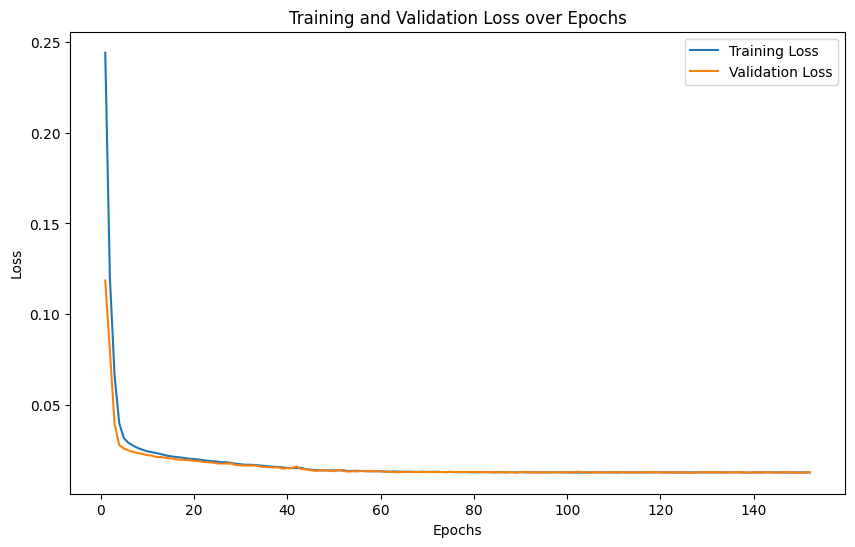

In [13]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_total_losses) + 1), train_total_losses, label='Training Loss')
plt.plot(range(1, len(val_total_losses) + 1), val_total_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


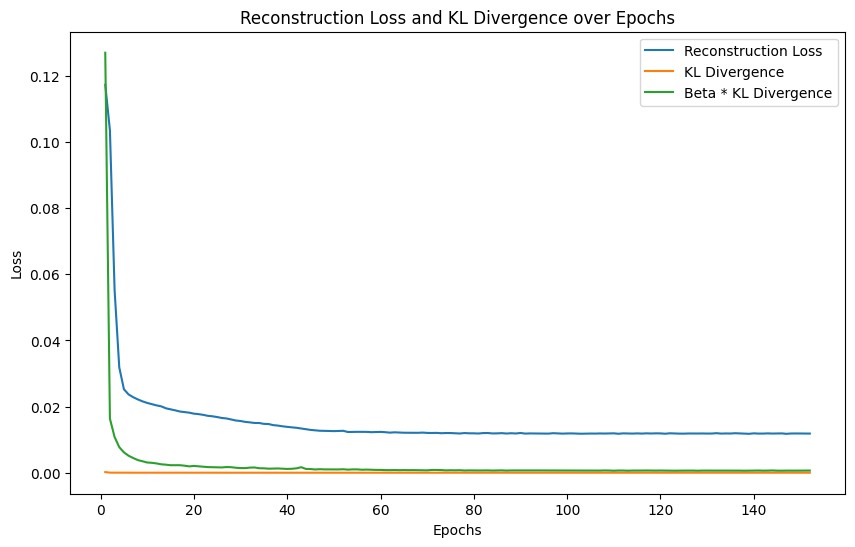

In [14]:
# Plot reconstruction loss and KL divergence over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_recon_losses) + 1), train_recon_losses, label='Reconstruction Loss')
plt.plot(range(1, len(train_kld_losses) + 1), train_kld_losses, label='KL Divergence')
plt.plot(range(1, len(train_total_losses) + 1), beta * np.array(train_kld_losses), label='Beta * KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss and KL Divergence over Epochs')
plt.legend()
plt.show()



In [15]:
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        x = data[0].to(device, dtype=torch.float)
        recon_batch, mu, logvar, z = model(x)
        loss , _ , _ = loss_function(recon_batch, x, mu, logvar)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Average Test Loss: {avg_test_loss:.4f}")


Average Test Loss: 0.0004


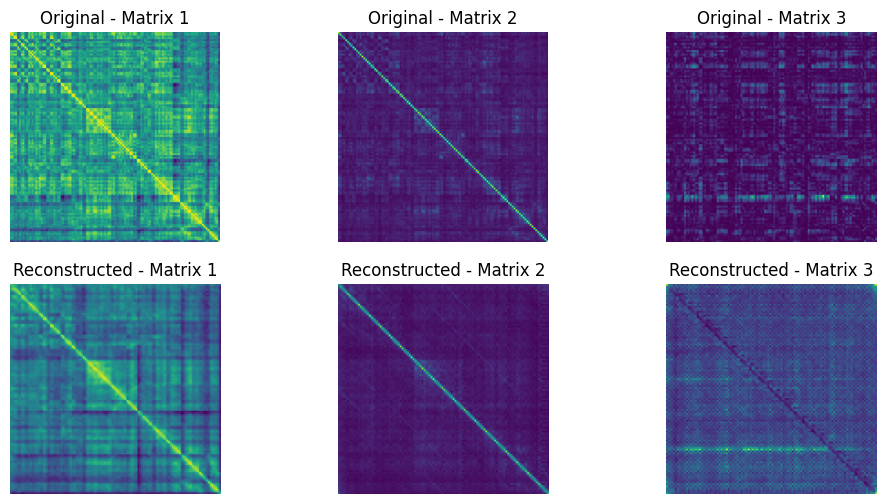

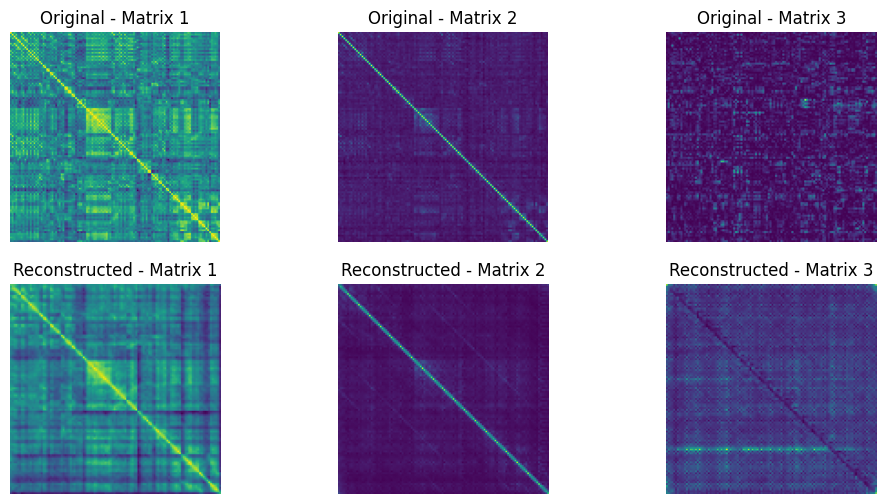

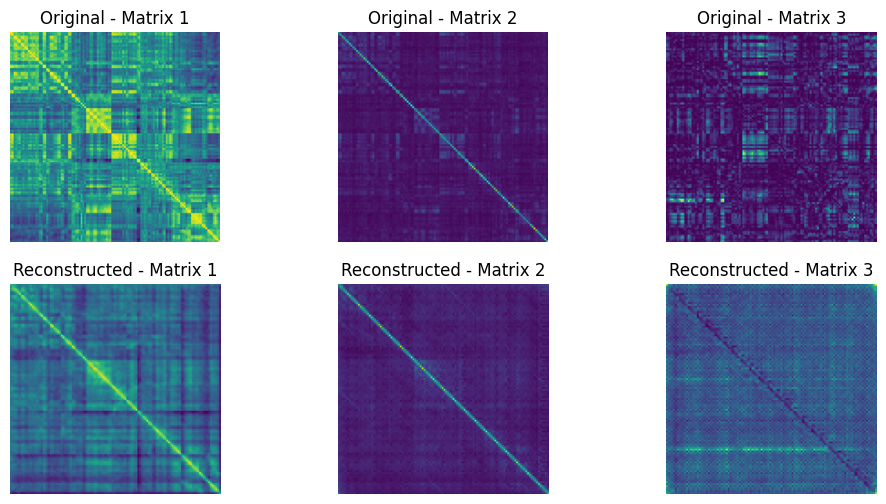

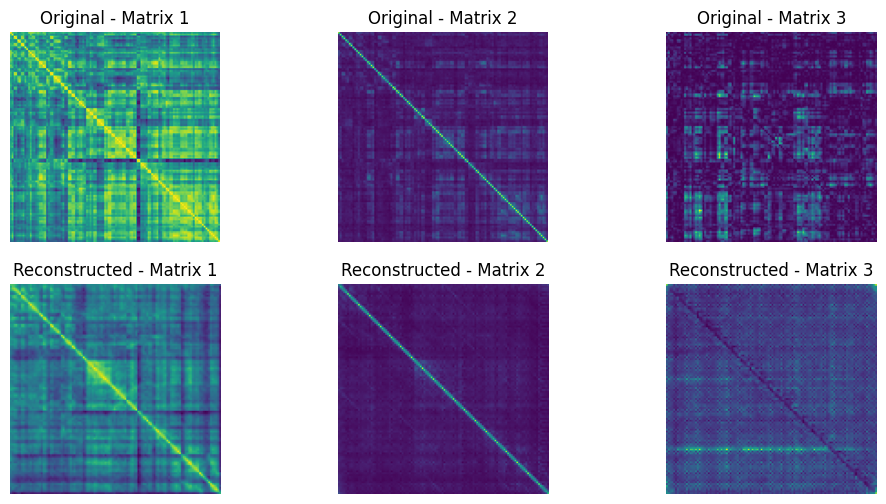

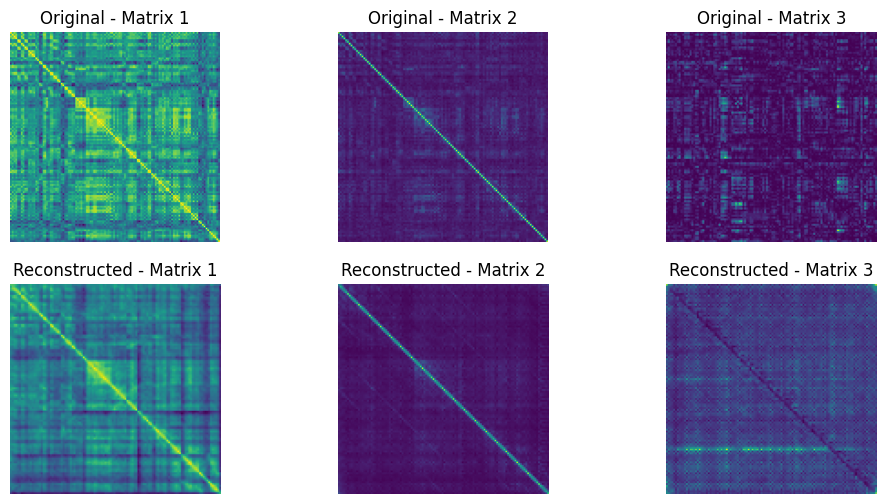

In [16]:
import matplotlib.pyplot as plt

# Function to display original and reconstructed images
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))
        x = data[0].to(device, dtype=torch.float)
        recon_x, _, _ , _ = model(x)
        
        # Move tensors to CPU and convert to numpy
        x = x.cpu().numpy()
        recon_x = recon_x.cpu().numpy()
        
        n = min(x.shape[0], 5)  # Number of samples to display
        for i in range(n):
            fig, axes = plt.subplots(2, 3, figsize=(12, 6))
            for j in range(3):
                axes[0, j].imshow(x[i, j], cmap='viridis')
                axes[0, j].set_title(f'Original - Matrix {j+1}')
                axes[0, j].axis('off')
                axes[1, j].imshow(recon_x[i, j], cmap='viridis')
                axes[1, j].set_title(f'Reconstructed - Matrix {j+1}')
                axes[1, j].axis('off')
            plt.show()

# Visualize reconstructions on test data
visualize_reconstruction(model, test_loader)


In [17]:
# Save the trained model
model_save_path = os.path.join(project_dir, 'conv_vae_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /home/diego/Escritorio/azheimer/conv_vae_model.pth


In [18]:
# Load the model
model = ConvVAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()


ConvVAE(
  (enc_conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=4608, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=4608, out_features=15, bias=True)
  (fc_decode): Linear(in_features=15, out_features=4608, bias=True)
  (dec_conv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv5)

In [19]:
model.eval()
latents = []
labels = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device, dtype=torch.float)
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        latents.append(z.cpu())
        labels.extend(label)  # Collect labels

# Concatenate all latent vectors and convert labels to a NumPy array
latents = torch.cat(latents, dim=0).numpy()
labels = np.array(labels)


In [20]:
from sklearn.manifold import TSNE

# Reduce latent dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)


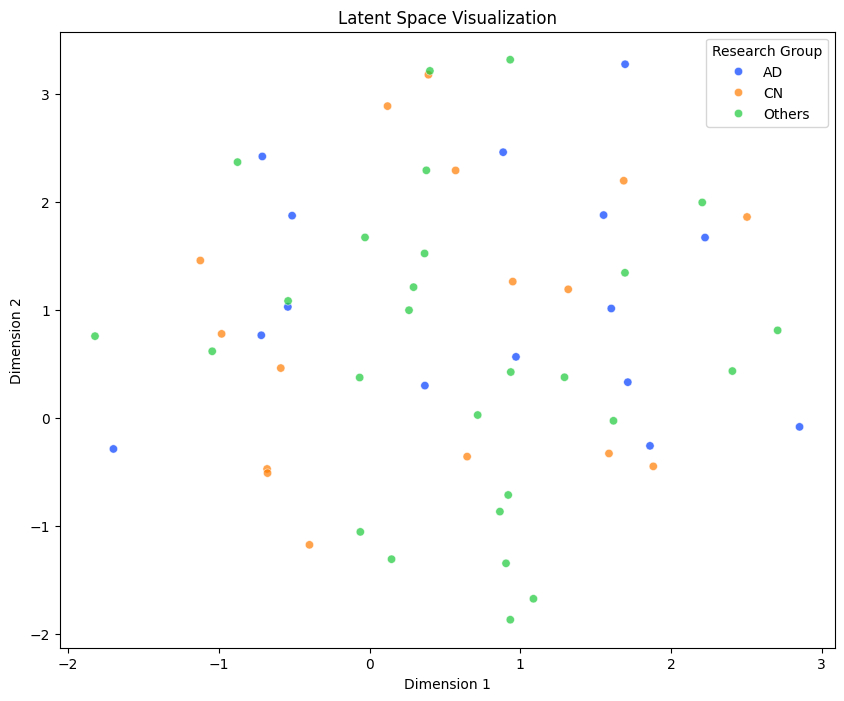

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
latent_df = pd.DataFrame({
    'Dimension 1': latents_2d[:, 0],
    'Dimension 2': latents_2d[:, 1],
    'Group': labels
})

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=latent_df,
    x='Dimension 1',
    y='Dimension 2',
    hue='Group',
    palette='bright',
    alpha=0.7
)
plt.title('Latent Space Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Research Group')
plt.show()


In [22]:
from sklearn.decomposition import PCA

# Reduce latent dimensions to 2D using PCA
pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents)


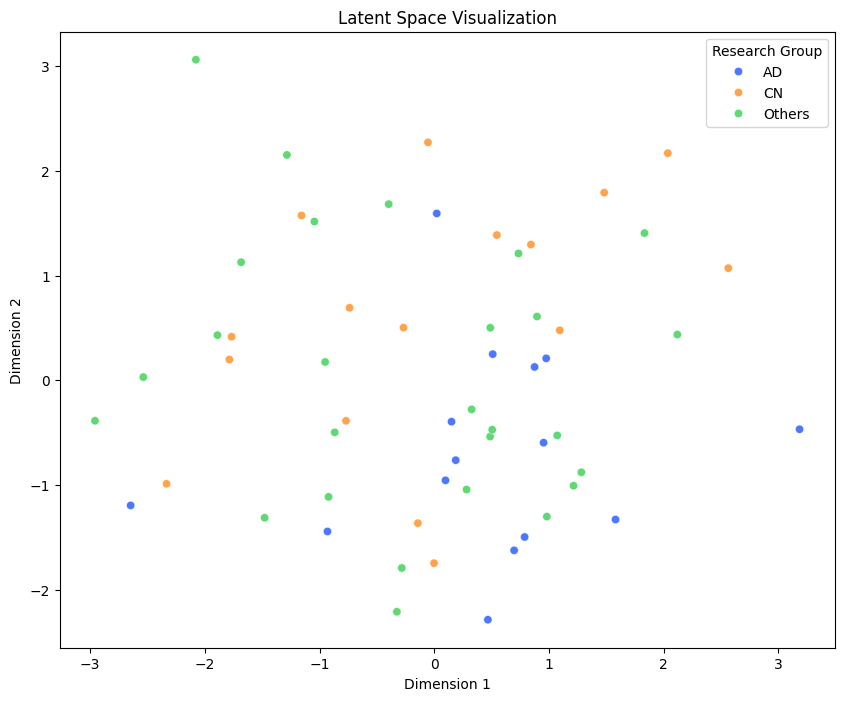

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
latent_df = pd.DataFrame({
    'Dimension 1': latents_2d[:, 0],
    'Dimension 2': latents_2d[:, 1],
    'Group': labels
})

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=latent_df,
    x='Dimension 1',
    y='Dimension 2',
    hue='Group',
    palette='bright',
    alpha=0.7
)
plt.title('Latent Space Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Research Group')
plt.show()


In [24]:
# Function to extract latent representations and labels for AD and CN subjects
def extract_latents_and_labels(file_paths, model, device):
    latents = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for fp in file_paths:
            file_name = os.path.basename(fp)
            group = file_name.split('_')[0]
            if group not in ['AD', 'CN']:
                continue  # Skip "Others" category
            label = 1 if group == 'AD' else 0  # Assign labels: AD=1, CN=0
            data = torch.load(fp)
            if isinstance(data, np.ndarray):
                data = torch.tensor(data)
            data = normalize_tensor(data)
            x = data.unsqueeze(0).to(device, dtype=torch.float)  # Add batch dimension
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy().squeeze())
            labels.append(label)
    return np.array(latents), np.array(labels)


In [25]:
# Combine train and validation file paths
train_val_set = train_set + val_set

# Extract latents and labels for training (train + validation sets)
X_train, y_train = extract_latents_and_labels(train_val_set, model, device)

# Extract latents and labels for test set
X_test, y_test = extract_latents_and_labels(test_set, model, device)

# Print the shapes
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Training data shape: (153, 15), Training labels shape: (153,)
Test data shape: (31, 15), Test labels shape: (31,)


In [26]:
from collections import Counter

print(f"Training labels distribution: {Counter(y_train)}")
print(f"Test labels distribution: {Counter(y_test)}")


Training labels distribution: Counter({1: 80, 0: 73})
Test labels distribution: Counter({0: 16, 1: 15})


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000),
}

# Dictionary to store performance metrics
performance_metrics = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    # Predict on test set
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    # Store metrics
    performance_metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc,
    }
    # Print classification report
    print(f"Classifier: {name}")
    print(classification_report(y_test, y_pred, target_names=["CN", "AD"]))
    print("-" * 50)


Classifier: Logistic Regression
              precision    recall  f1-score   support

          CN       0.64      0.56      0.60        16
          AD       0.59      0.67      0.62        15

    accuracy                           0.61        31
   macro avg       0.62      0.61      0.61        31
weighted avg       0.62      0.61      0.61        31

--------------------------------------------------
Classifier: SVM (Linear Kernel)
              precision    recall  f1-score   support

          CN       0.67      0.50      0.57        16
          AD       0.58      0.73      0.65        15

    accuracy                           0.61        31
   macro avg       0.62      0.62      0.61        31
weighted avg       0.62      0.61      0.61        31

--------------------------------------------------
Classifier: Random Forest
              precision    recall  f1-score   support

          CN       0.62      0.62      0.62        16
          AD       0.60      0.60      0.60  